## Clean your data with unsupervised machine learning
https://towardsdatascience.com/clean-your-data-with-unsupervised-machine-learning-8491af733595

Data - National anthems: <br>
https://medium.com/@lucasdesa/text-clustering-with-k-means-a039d84a941b <br> https://github.com/lucas-de-sa/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb

Additional References: <br>
https://towardsdatascience.com/a-friendly-introduction-to-text-clustering-fa996bcefd04

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('anthems.csv')
data.head()

,Country,Alpha-2,Alpha-3,Continent,Anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."


### Data Cleaning
- missingno highlights any missing info
- able to sample rows so can easily handle very large data frames

<AxesSubplot:>

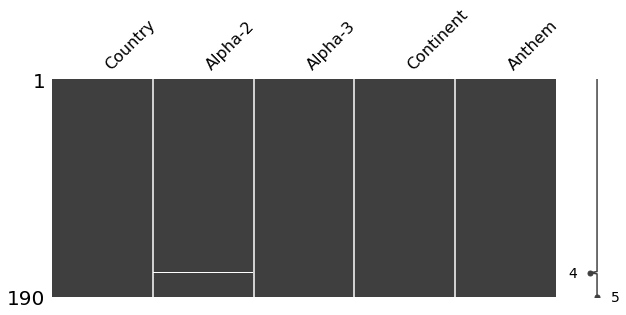

In [13]:
msno.matrix(data, figsize=(10,4))

In [18]:
# one missing value
data[data['Alpha-2'].isnull()]

,Country,Alpha-2,Alpha-3,Continent,Anthem
168,Namibia,NaN,NAM,Africa,Namibia land of the brave Freedom fight we he ...


In [26]:
 pd.options.display.max_colwidth = 200
data['Anthem'][:1]

0    Around our flag we stand united, With one wish and one goal, A sacred oath we bestow upon it Proclaiming loyalty for our salvation. From war abstains only he, Who a traitor is born, He who is a tr...
Name: Anthem, dtype: object

In [64]:
# data in Unicode, but you will need to represent it in ASCII for Clustering II
data['Anthem'][18][0:447]

"O Lord, bless the nation of Hungary With your grace and bounty Extend over it your guarding arm During strife with its enemies Long torn by ill fate Bring upon it a time of relief This nation has suffered for all sins Of the past and of the future! You brought our ancestors up Over the Carpathians' holy peaks By You was won a beautiful homeland For Bendeguz's sons And wherever flow the rivers of The Tisza and the Danube ÃƒÂ\x81rpÃƒÂ¡d our hero's "

#### Using ML to split out some corrupted texts
- cluster data into clean and messy

In [34]:
# create features

def uniqueWords(X):
    X = X.split(' ')
    X = set(X)
    X = len(X)
    return X

data['charCount']   = data['Anthem'].str.len() # character count
data['wordCount']   = data['Anthem'].str.split(' ').str.len() # word count
data['uniqueWords'] = data['Anthem'].apply(uniqueWords) # unique words count

Text(0.5, 1.0, 'Text Data Quality')

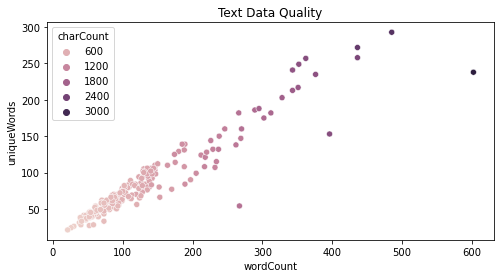

In [52]:
# visualize the data using the new featrues we have just created
 
plt.figure(figsize=(8,4))
sns.scatterplot(data=data,x='wordCount',y='uniqueWords',hue='charCount')
plt.title('Text Data Quality')

It looks like there is a clear trend of increasing words and unique words. We couldn't clearly clusters of items suggesting out data is fairly clean. There are only 3 points that have a slightly different trend from the rest. <br> If the character count was high but the word count was small we'd expect the data to have some messy characters.

In [50]:
# a lot of characters
data[(data['uniqueWords']>200)&(data['wordCount']>500)]

,Country,Alpha-2,Alpha-3,Continent,Anthem,charCount,wordCount,uniqueWords
52,Peru,PE,PER,South_America,"We are free! May we always be so, may we always be so! And may the Sun renounce its light, its light, its light, Before we break the solemn vow which the homeland lifted up to the Eternal, Before ...",3268,602,238


### Clustering I 
- see if we can split out each of the areas that we see in the chart

In [54]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [56]:
# standardize the data
X = data[['charCount','wordCount','uniqueWords']]
scaler = StandardScaler()
X = scaler.fit_transform(X)

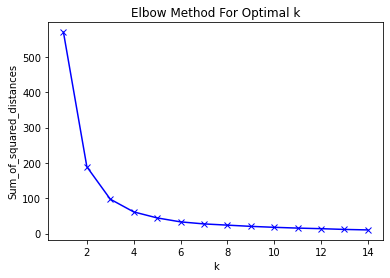

In [59]:
# Elbow Method to define number of k for the clustering
sum_of_squared_distances = []
K = range(1,15)

for k in K:
    km = KMeans(n_clusters=k, random_state=20)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)
    
# Plot it
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [60]:
# looking at the plot the elbow seems to be at 3 or k=3
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
data['Cluster'] = kmeans.labels_

Text(0.5, 1.0, 'Text Data Quality')

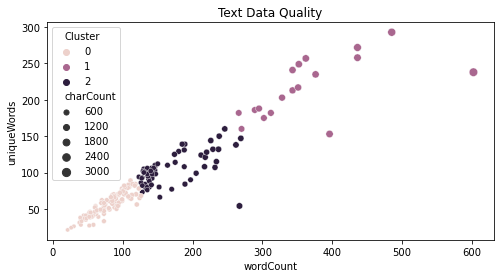

In [61]:
plt.figure(figsize=(8,4))
sns.scatterplot(data=data,x='wordCount',y='uniqueWords',hue='Cluster',size='charCount')
plt.title('Text Data Quality')

As expected we get some well defined clusters

### Clustering II
- let's see if we can divide natinal anthems into groups with some having more militaristic lyrics, such a France’s, others being more patriotic complimenting it’s rich nature, such as Brazil’s

In [7]:
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

#### Pre-processing of the Anthems

In [3]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(tokens, words):
    return [token for token in tokens if token not in words]

# applies stemming to a list of tokenized words
def applyStemming(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(tokens):
    twoLetterWord = []
    for token in tokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [4]:
data['Anthem'][19]

"Our country's God! Our country's God! We worship Thy name in its wonder sublime. The suns of the heavens are set in Thy crown By Thy legions, the ages of time! With Thee is each day as a thousand years, Each thousand of years, but a day, Eternity's flow'r, with its homage of tears, That reverently passes away. Iceland's thousand years, Iceland's thousand years! Eternity's flow'r, with its homage of tears, That reverently passes away. Our God, our God, we bow to Thee, Our spirits most fervent we place in thy care. Lord, God of our fathers from age unto age, We are breathing our holiest prayer. We pray and we thank Thee a thousand years For safely protected we stand; We pray and we bring Thee our homage of tears Our destiny rest in Thy hand. IcelandÃ¢â‚¬â„¢s thousand years, Iceland's thousand years! The hoarfrost of morning which tinted those years, Thy sun rising high, shall command! Our countryÃ¢â‚¬â„¢s God! Our countryÃ¢â‚¬â„¢s God! Our life is a feeble and quivering reed; We perish,

In [5]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    
    countries_list = [line.rstrip('\n') for line in open('lists/countries.txt')] # Load .txt file line by line
    nationalities_list = [line.rstrip('\n') for line in open('lists/nationalities.txt')] # Load .txt file line by line
    other_words = [line.rstrip('\n') for line in open('lists/stopwords_scrapmaker.txt')] # Load .txt file line by line
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index]) # split text into words
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, countries_list)
        listOfTokens = removeWords(listOfTokens, nationalities_list)
        listOfTokens = removeWords(listOfTokens, other_words)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index]) # text data in Unicode, but you need to represent it in ASCII

    return corpus

In [8]:
language = 'english'
corpus = processCorpus(data['Anthem'].tolist(), language)
corpus[19]

'countri god countri god worship sublim sun heaven set crown legion age time day thousand year thousand year day etern flow homag tear rever pass thousand year thousand year etern flow homag tear rever pass god god bow spirit fervent place care lord god father age age breath holiest prayer pray thousand year safe protect stand pray bring homag tear destini rest hand icelandaC/a,!a thousand year thousand year hoarfrost morn tint year sun rise high command countryaC/a,!a god countryaC/a,!a god life feebl quiver reed perish depriv spirit light redeem uphold inspir morn courag love lead day strife send peac heaven safeguard nation life icelandaC/a,!a thousand year thousand year prosper peopl diminish tear guid wisdom life'

#### Feature Extraction with TF-IDF
- how important a word is to a corpus by giving each word a weight between 0 and 1

TF-IDF method has 2 steps:
- measures how frequently a term t occurs in a document giving higher weights to more frequent terms
- the importance of a term in a set of documents - the more frequent the term is the lower the importance

In [13]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf.copy()

print("{} rows".format(final_df.shape[0]))

# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0) 

190 rows


,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
sacr,0.314285,0.000000,0.000000,0.000000,0.095563,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
fatherland,0.254830,0.130993,0.077471,0.207215,0.000000,0.083289,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
proclaim,0.246156,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.117607
flag,0.220666,0.113431,0.000000,0.059811,0.067097,0.000000,0.0,0.000000,0.0,0.0,...,0.098082,0.0,0.0,0.0,0.0,0.07072,0.0,0.0,0.067148,0.070286
earth,0.202957,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.218313,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000


#### K-Means

In [26]:
from sklearn import cluster
from wordcloud import WordCloud

In [17]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [18]:
k = 8
kmeans_results = run_KMeans(k, final_df)

C:\Users\astas\Miniconda3\envs\training\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\astas\Miniconda3\envs\training\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\astas\Miniconda3\envs\training\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\astas\Miniconda3\envs\training\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jo

In [19]:
kmeans_results

{2: KMeans(algorithm='full', n_clusters=2, n_jobs=-1, random_state=1),
 3: KMeans(algorithm='full', n_clusters=3, n_jobs=-1, random_state=1),
 4: KMeans(algorithm='full', n_clusters=4, n_jobs=-1, random_state=1),
 5: KMeans(algorithm='full', n_clusters=5, n_jobs=-1, random_state=1),
 6: KMeans(algorithm='full', n_clusters=6, n_jobs=-1, random_state=1),
 7: KMeans(algorithm='full', n_clusters=7, n_jobs=-1, random_state=1),
 8: KMeans(algorithm='full', n_jobs=-1, random_state=1)}

#### Cluster Analysis

In [20]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

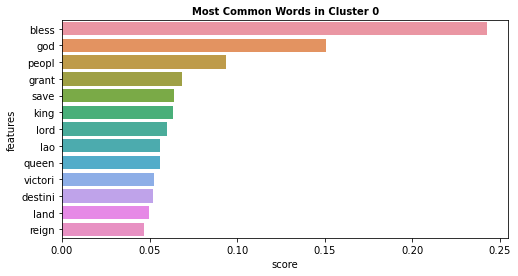

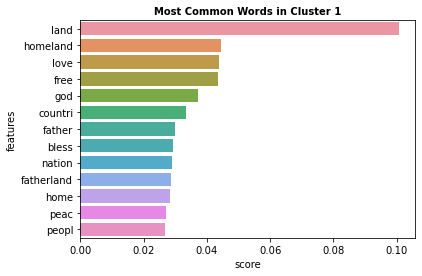

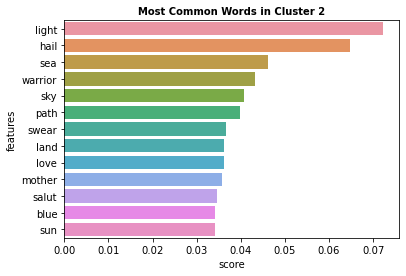

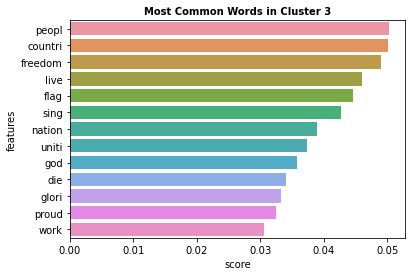

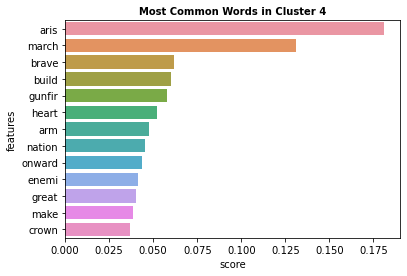

In [21]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [22]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

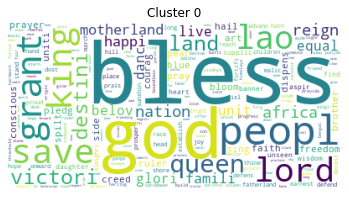

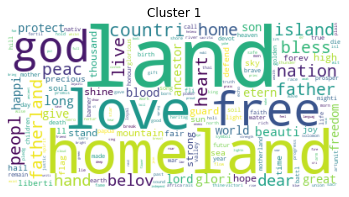

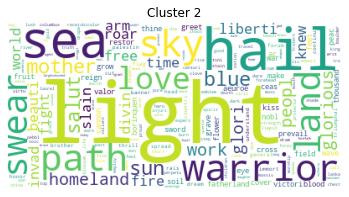

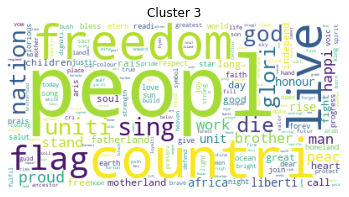

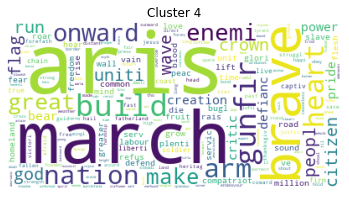

In [27]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [28]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
data['label'] = labels
data.head()

,Country,Alpha-2,Alpha-3,Continent,Anthem,label
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish...",3
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo...",3
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ...",1
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",3
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea...",0


## To Do:
- TF-IDF - change the arguments
- Find optimal number of clusters and re-run K-means
- Try using DBSCAN and compare with K-means
- Find methods to assess how good clusters are
- Build a multi-classification model and assess how well it performs on a test set